In [19]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import numpy as np

In [20]:
# Dataset path
dataset_path = r"C:\Users\HP\OneDrive\Desktop\Minor Project 6 th sem\dataset\farm_insects"

In [21]:
# Image settings
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

In [22]:
# Fix PIL transparency issue
def convert_image(img):
    if isinstance(img, np.ndarray):  # Check if input is already an image array
        return img
    img = Image.open(img)
    if img.mode in ("P", "RGBA"):  # Convert Palette/Transparent images to RGB
        img = img.convert("RGB")
    return np.array(img)

In [23]:
# Data augmentation (removed `preprocessing_function` to avoid error)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

In [24]:
# Load training data
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

Found 1269 images belonging to 14 classes.


In [25]:
# Load validation data
val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

Found 310 images belonging to 14 classes.


In [26]:
# Load InceptionV3 model with ImageNet weights
base_model =  DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


In [27]:
# Enable fine-tuning for better learning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

In [28]:
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_data.num_classes, activation='softmax')(x)

In [29]:
# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

In [30]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [32]:
# Train the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 618s 13s/step - accuracy: 0.0807 - loss: 3.0405 - val_accuracy: 0.4097 - val_loss: 2.0792 - learning_rate: 1.0000e-04
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 499s 12s/step - accuracy: 0.3093 - loss: 2.2007 - val_accuracy: 0.5032 - val_loss: 1.6657 - learning_rate: 1.0000e-04
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 527s 13s/step - accuracy: 0.4456 - loss: 1.7326 - val_accuracy: 0.6065 - val_loss: 1.2770 - learning_rate: 1.0000e-04
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 506s 13s/step - accuracy: 0.5730 - loss: 1.3434 - val_accuracy: 0.6258 - val_loss: 1.0959 - learning_rate: 1.0000e-04
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 553s 14s/step - accuracy: 0.6534 - loss: 1.0481 - val_accuracy: 0.6484 - val_loss: 0.9816 - learning_rate: 1.0000e-04
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 578s 14s/step - accuracy: 0.7224 - loss: 0.9018 - val_accuracy: 0.6903 - val_loss: 0.9476 - learning_rate: 1.0000e-04
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 572s 14s/step - accuracy: 

In [33]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.7597 - loss: 0.7535
Validation Accuracy: 74.52%


In [34]:
# Save the model
model.save("pest_detection_model8_v2.h5")

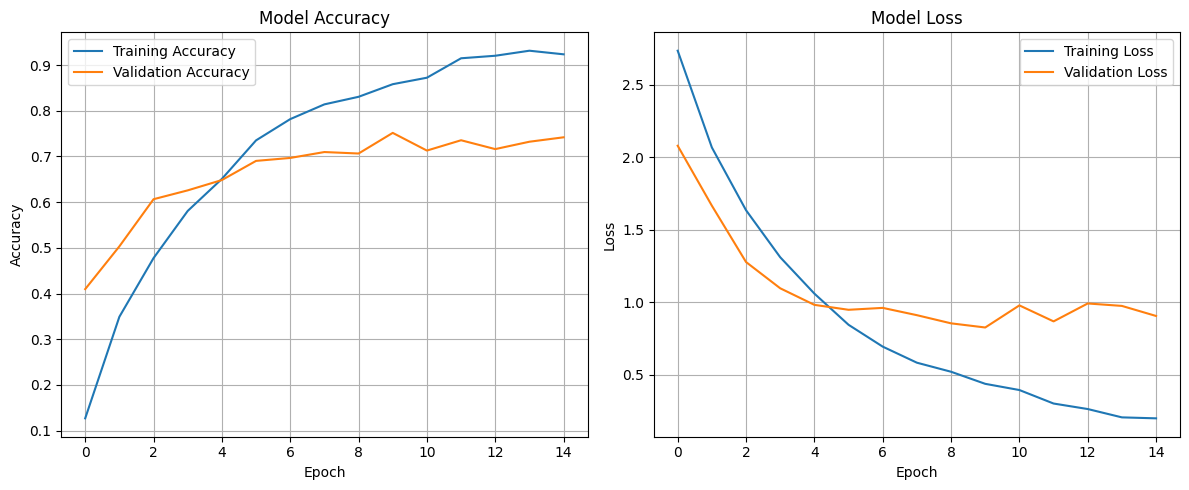

In [35]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [37]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")

Final Training Accuracy: 0.9236


In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 8s/step


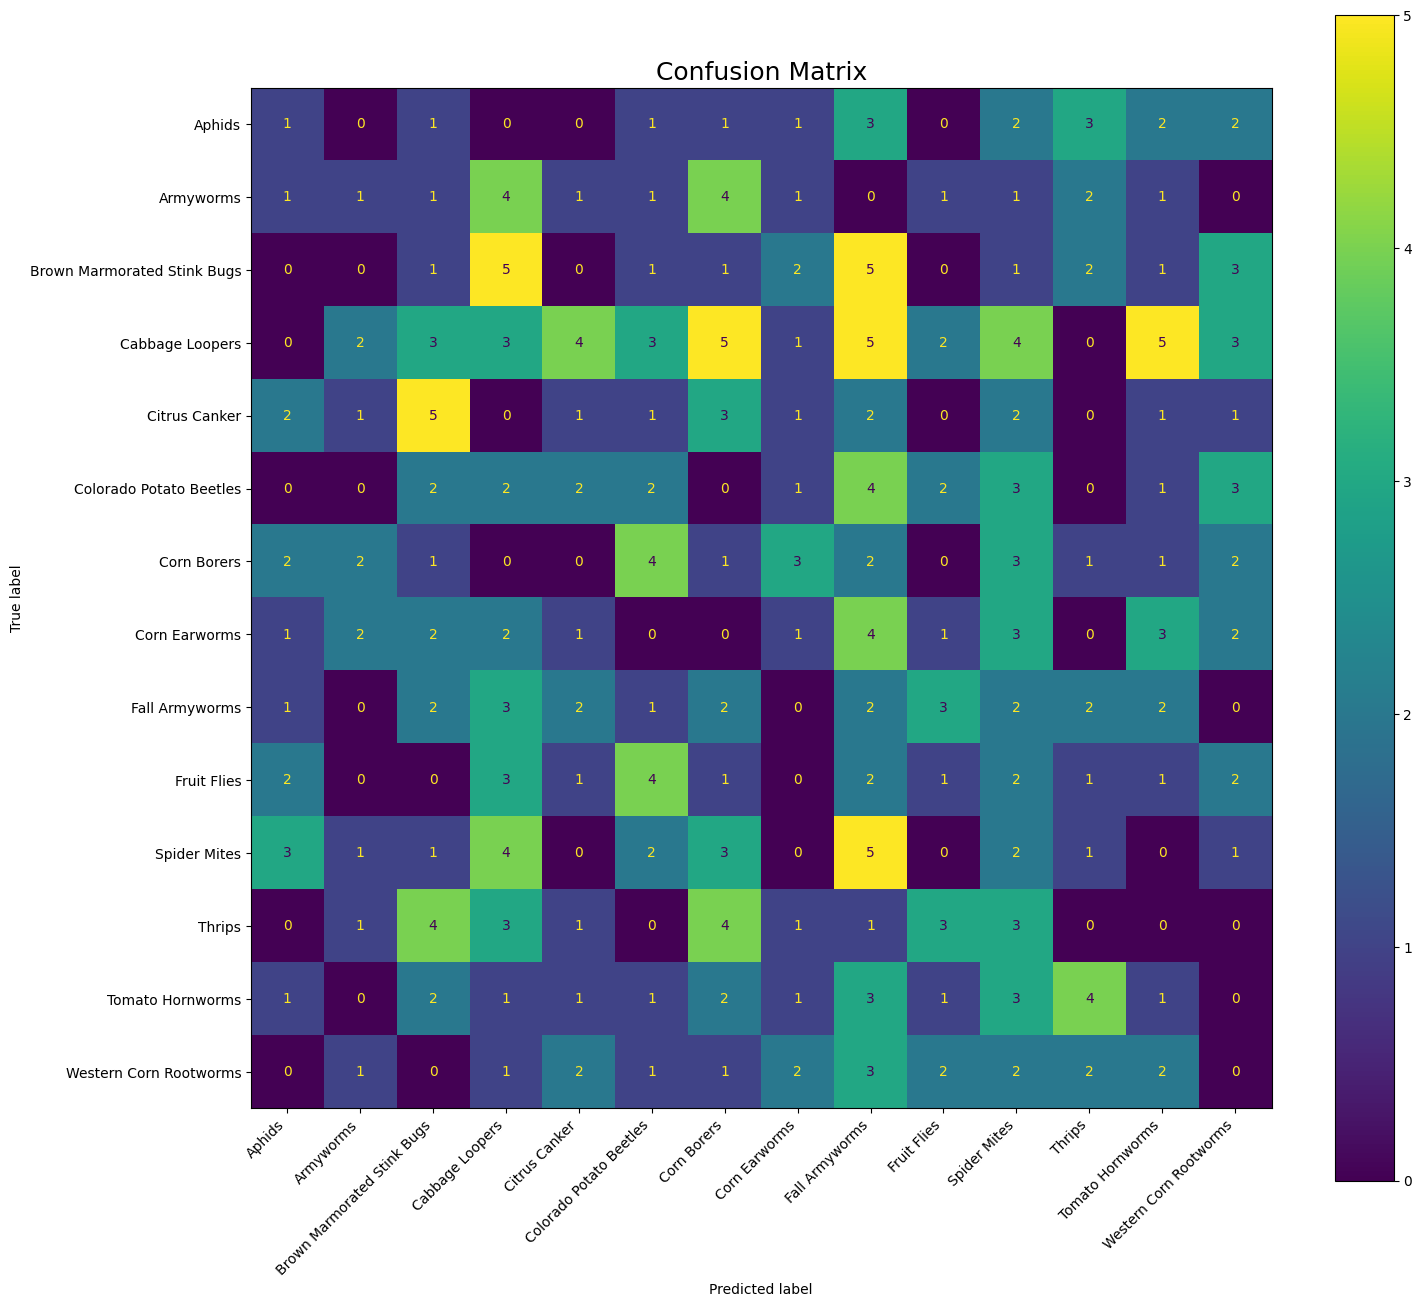

In [39]:

val_data.reset()

# Predict and get class indices
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot with more space
fig, ax = plt.subplots(figsize=(16, 14))  # Larger figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(
    cmap='viridis',
    xticks_rotation=45,
    values_format='d',
    ax=ax
)
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout(pad=3.0)  # Add padding to avoid cutoff
plt.grid(False)
plt.show()